# Querying and Visualizing Linked Open Data with SPARQL and Python

This notebook walks through a process for querying and processing data from Wikidata, one of the largest openly available datasets in the world. First we construct a query with SPARQL, the query language for RDF. Next, we call the Wikidata endpoint using Python and encode the returned data as a pandas dataframe. Then we aggregate the data into groups and create a simple data visualization with pandas. 

## Resources
- [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page)
- [SPARQL tutorial](https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial)
- [Python's pandas library](https://pandas.pydata.org/)


In [4]:
# Import libraries and set some pandas defaults. 
import json
from collections import OrderedDict
import pandas as pd
import requests

pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 25)

In [5]:
# Declare the url for the Wikidata SPARQL endpoint.
url = "https://query.wikidata.org/sparql"

In [6]:
# Declare your SPARQL query. This one queries Wikidata for US-based publicly funded companies and returns founders, inception date(s), industries, maximum number of employees, 
# and maximum annual revenue. 

query = """
SELECT
  ?company ?companyLabel
  (GROUP_CONCAT(DISTINCT ?inceptionLabel;separator=", ") AS ?inceptions)
  (GROUP_CONCAT(DISTINCT ?foundedByLabel;separator=", ") AS ?founders)
  (GROUP_CONCAT(DISTINCT ?industryLabel;separator=", ") AS ?industries)
  (MAX (?numEmployees) AS ?maxEmployees)
  (MAX(?revenue) as ?maxRevenue)
WHERE {
  ?company wdt:P31 wd:Q891723 .
  ?company wdt:P17 wd:Q30 .
  OPTIONAL { ?company wdt:P571 ?inception . }
  OPTIONAL { ?company wdt:P112 ?foundedBy . }
  OPTIONAL { ?company wdt:P452 ?industry . }

  ?company p:P1128 ?statement1 .
  ?statement1 ps:P1128 ?numEmployees .

  ?company p:P2139 ?statement .
  ?statement ps:P2139 ?revenue .

  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
              ?foundedBy rdfs:label ?foundedByLabel .
              ?company rdfs:label ?companyLabel .
              ?inception rdfs:label ?inceptionLabel .
              ?industry rdfs:label ?industryLabel .
              }
}
GROUP BY ?company ?companyLabel ?inceptions ?founders ?industries
ORDER BY DESC(?maxRevenue)
"""

In [7]:
# Send a HTTP request to the Wikidata endpoint with the SPARQL code stored as a URL parameter _query_. 
r = requests.get(url, params={"format": "json", "query": query})

In [8]:
# Encode the returned data as json.
data = r.json()

In [9]:
# Parse the resulting json into dictionary objects and append them to a list named companies.
companies = []
for item in data["results"]["bindings"]:
    companies.append(
        OrderedDict(
            {
                "uri": item["company"]["value"],
                "company": item["companyLabel"]["value"],
                "founded": (item["inceptions"]["value"].split("-")[0])
                if "inceptions" in item
                else None,
                "founders": item["founders"]["value"] if "founders" in item else None,
                # Note that our SPARQL query returns a comma-separated list of industries, which might be useful for certain types of analysis.
                # For simplicity, we write just the first industry in the list to the dictionary. 
                "industry": (item["industries"]["value"].split(", ")[0])
                if "industries" in item
                else None,
                "maxRevenue": item["maxRevenue"]["value"]
                if "maxRevenue" in item
                else None,
                "maxEmployees": item["maxEmployees"]["value"]
                if "maxEmployees" in item
                else None
            }
        )
    )

In [10]:
# Convert companies to a dataframe, set the index to be the unique URI column, 
# and cast the maxRevenue column from a string to a float datatype.
df = pd.DataFrame(companies)
df.set_index("uri", inplace=True)
df = df.astype(
    {"maxRevenue": float}
)

In [11]:
# Take a look at the first 25 values in the new dataframe. 
df.head(25)

,company,founded,founders,industry,maxRevenue,maxEmployees
uri,,,,,,
http://www.wikidata.org/entity/Q483551,Walmart,1962,Sam Walton,retail,5.592e+11,2500000
http://www.wikidata.org/entity/Q156238,ExxonMobil,1999,John D. Rockefeller,petroleum industry,4.864e+11,75000
http://www.wikidata.org/entity/Q3884,Amazon,1994,Jeff Bezos,retail,3.861e+11,1298000
http://www.wikidata.org/entity/Q312,Apple Inc.,1976,"Steve Jobs, Ronald Wayne, Steve Wozniak",electronics,3.658e+11,154000
http://www.wikidata.org/entity/Q624375,CVS Health,2007,,retail,2.687e+11,300000
http://www.wikidata.org/entity/Q2103926,UnitedHealth Group,1977,,health care,2.571e+11,58000
http://www.wikidata.org/entity/Q217583,Berkshire Hathaway,1955,Oliver Chace,insurance,2.546e+11,361270
http://www.wikidata.org/entity/Q570473,McKesson Corporation,1833,,distributor,2.382e+11,68000
http://www.wikidata.org/entity/Q214763,ConocoPhillips,2002,,petroleum industry,1.987e+11,39000


In [12]:
# We're interested in which industries create the highest revenue, so we will group the companies by industry using
# the pandas groupby function.
ind_group = df.groupby("industry")

# View a listing of each discrete grouping by iterating over the groups: 
for industry, industry_df in ind_group:
    print(industry)


3D printing
Internet
aerospace
aerospace engineering
aerospace industry
air transport
analytics
arms industry
automotive industry
bank
banking industry
biotechnology
bookselling
broadcasting
chemical industry
clothing industry
computer data storage
computer hardware
conglomerate
construction
consumer electronics
distributor
e-commerce
electrical industry
electricity generation
electronics
energy industry
engineering
enterprise software
fast casual restaurant
fast food
ferrous metallurgy
financial service
food industry
food processing
foodservice
freight transport industry
game industry
gastronomy
health care
information technology
insurance
insurance industry
investment
life insurance
list of oil exploration and production companies
logistics
machine industry
manufacturing
mass media
mechanical engineering
media industry
medical device industry
medical equipment
network security
personal care products
petroleum industry
pharmaceutical industry
quaternary sector of the economy
real est

In [13]:
# To investigate a specific group, call the .get_group method on a group name: 
ind_group.get_group("retail")

,company,founded,founders,industry,maxRevenue,maxEmployees
uri,,,,,,
http://www.wikidata.org/entity/Q483551,Walmart,1962,Sam Walton,retail,5.592e+11,2500000
http://www.wikidata.org/entity/Q3884,Amazon,1994,Jeff Bezos,retail,3.861e+11,1298000
http://www.wikidata.org/entity/Q624375,CVS Health,2007,,retail,2.687e+11,300000
http://www.wikidata.org/entity/Q715583,Costco,1983,"James Sinegal, Jeffrey Brotman",retail,1.959e+11,254000
http://www.wikidata.org/entity/Q153417,Kroger,1883,Bernard Kroger,retail,1.325e+11,453000
http://www.wikidata.org/entity/Q864407,The Home Depot,1978,"Arthur Blank, Bernard Marcus, Pat Farrah, Ron ...",retail,1.321e+11,400000
http://www.wikidata.org/entity/Q1046951,Target,1902,George Dayton,retail,9.356e+10,345000
http://www.wikidata.org/entity/Q1591889,Walgreens,1901,"Charles Rudolph Walgreen, Sr.",retail,6.742e+10,210500
http://www.wikidata.org/entity/Q785943,Staples Inc.,1986,Leo Kahn,retail,2.249e+10,79075


In [14]:
# Create a series to calculate the average revenue by industry and display the top 10 results.
ind_mean = df.groupby("industry")["maxRevenue"].mean().sort_values(ascending=False).head(10)

In [15]:
# View the grouping in table format.  
print(ind_mean)

industry
insurance              2.546e+11
distributor            2.382e+11
petroleum industry     1.829e+11
technology industry    1.681e+11
health care            1.457e+11
retail                 1.360e+11
electronics            1.163e+11
bank                   1.123e+11
computer hardware      1.029e+11
arms industry          1.011e+11
Name: maxRevenue, dtype: float64


<AxesSubplot:title={'center':'Top industries by average revenue'}, ylabel='industry'>

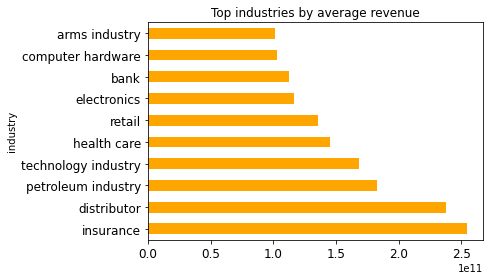

In [16]:
# To visualize the data more clearly, create a horizontal bar chart.  
ind_mean.plot(kind="barh", fontsize=12, color='orange', title="Top industries by average revenue")